In [25]:
import pandas as pd
import copy
import numpy as np
import networkx as nx
from netwulf import visualize
import matplotlib.pyplot as plt

### Loading Data

In [26]:
df = pd.read_csv("data/anonymous_data.csv")

In [27]:
df[5:10]

,ID,eta,Sesso,alloggio_pendolare,tempo_libero,pranzo,studiare,fuori
5,144,19,Femmina,Faccio il pendolare,"Programmare, Giocare ai Videgames, Praticare S...",107,107,107
6,192,19,Maschio,Alloggio a Perugia,"Giocare ai Videgames, Praticare Sport, Guardar...",129,129,129
7,203,19,Maschio,Alloggio a Perugia,"Programmare, Giocare ai Videgames, Guardare se...",101,101,101
8,197,18,Maschio,Alloggio a Perugia,"Programmare, Uscire",200,200,200
9,161,19,Maschio,Alloggio a Perugia,"Programmare, Giocare ai Videgames, Leggere fum...",NaN,NaN,NaN


### Graph Creation and Social Network Visualization

In [28]:
G = nx.Graph()
columns = ['pranzo', 'studiare', 'fuori']
for feature in columns:
  for index, utente in df[['ID', feature]].iterrows():
    # G.add_node(utente[0]) # add also singleton
    if pd.isna(utente[1]):
      continue
    link = utente[1].split(' ')
    for txt in link:
      if txt.isnumeric():
        G.add_edge(utente[0], int(txt))

In [29]:
print(f'Num nodes: {len(list(G.nodes))}')
print(f'Num edges: {len(list(G.edges))}')

Num nodes: 34
Num edges: 42


In [30]:
sorted(list(nx.degree_centrality(G).items()), key=lambda x: x[1], reverse=True)

[(115, 0.30303030303030304),
 (114, 0.18181818181818182),
 (178, 0.12121212121212122),
 (201, 0.12121212121212122),
 (136, 0.12121212121212122),
 (134, 0.12121212121212122),
 (87, 0.09090909090909091),
 (197, 0.09090909090909091),
 (200, 0.09090909090909091),
 (205, 0.09090909090909091),
 (108, 0.09090909090909091),
 (187, 0.09090909090909091),
 (118, 0.09090909090909091),
 (111, 0.09090909090909091),
 (203, 0.06060606060606061),
 (122, 0.06060606060606061),
 (164, 0.06060606060606061),
 (215, 0.06060606060606061),
 (83, 0.06060606060606061),
 (212, 0.06060606060606061),
 (202, 0.06060606060606061),
 (196, 0.06060606060606061),
 (101, 0.030303030303030304),
 (144, 0.030303030303030304),
 (107, 0.030303030303030304),
 (192, 0.030303030303030304),
 (129, 0.030303030303030304),
 (99, 0.030303030303030304),
 (185, 0.030303030303030304),
 (165, 0.030303030303030304),
 (170, 0.030303030303030304),
 (175, 0.030303030303030304),
 (180, 0.030303030303030304),
 (120, 0.030303030303030304)]

#### Utilities function

In [31]:
def plot_network(G):
    colors = [G[u][v].get('color','black') for u,v in G.edges()]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), dpi=80)

    # Visualization 1
    pos_attrs1 = {}
    circPos1 = nx.shell_layout(G)
    for node, coords in circPos1.items():
        pos_attrs1[node] = (coords[0]+0.01, coords[1]-.05)
    nx.draw_networkx_labels(G,pos=circPos1, ax=axes[0]) 
    nx.draw(G,pos=pos_attrs1, node_size=40, ax=axes[0], edge_color=colors)
    axes[0].set_title('Visualization1')

    # Visualization 2
    pos_attrs2 = {}
    circPos2 = nx.spring_layout(G, k=0.2, iterations=20)
    for node, coords in circPos2.items():
        pos_attrs2[node] = (coords[0]+0.01, coords[1]-.05)
    nx.draw_networkx_labels(G,pos=circPos2, ax=axes[1]) 
    nx.draw(G,pos=pos_attrs2, node_size=40, ax=axes[1], edge_color=colors)
    axes[1].set_title('Visualization2')

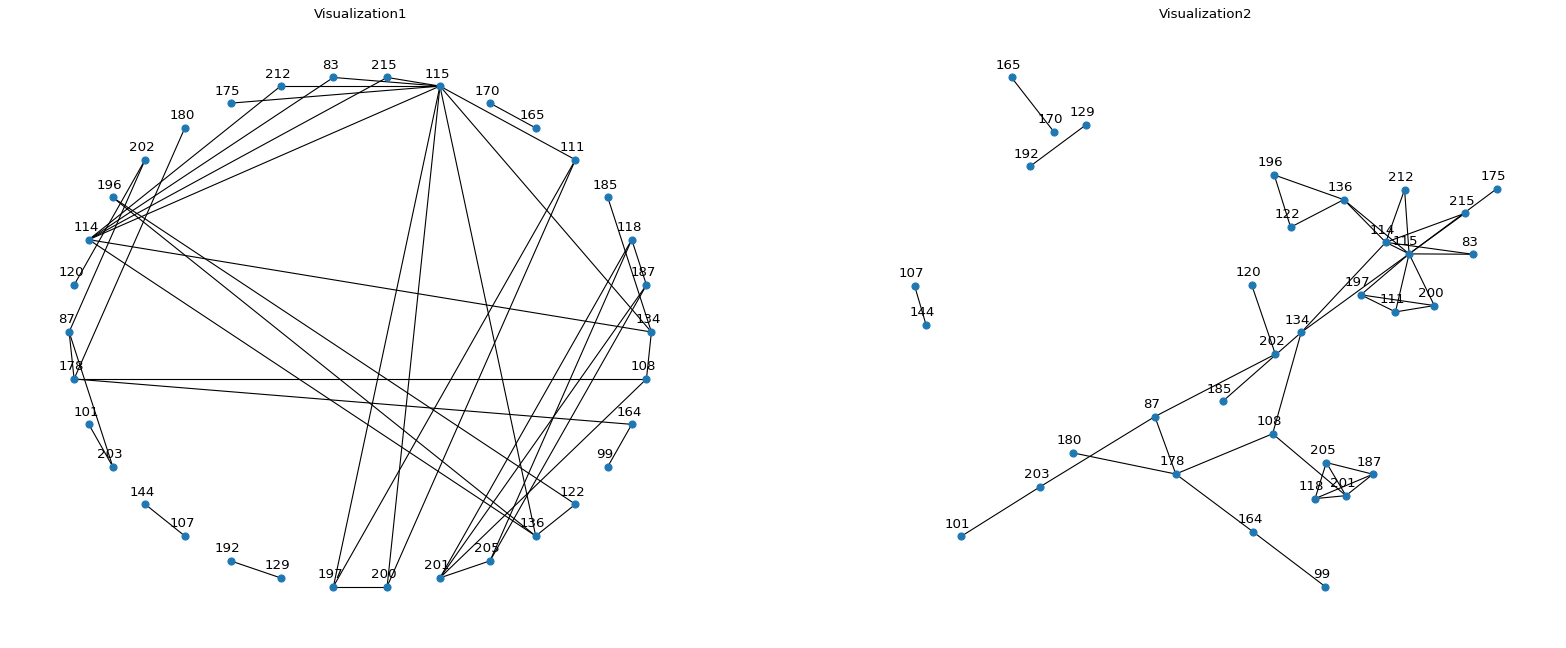

In [32]:
plot_network(G)

## Social Network Analysis

### Methods used for Link Prediction:
- **Similarity Approach**
    - ***Local Similarity***
        - common_neighbors
        - adamic_adar
        - jaccard
        - node_clustering
    - ***Gloabal Similarity***
        - katz_index
        - link_prediction_rwr
        - sim_rank
    - ***Quasi Local Similarity***
        - local_path_index
        - path_of_length_three
- **Probabilistic Method**
    - stochastic_block_model
- **Information Theory Approach**
    - path_entropy


In [33]:
# Import all needed methods
from cnlp.similarity_methods.local_similarity import common_neighbors, adamic_adar, jaccard, node_clustering
from cnlp.similarity_methods.global_similarity import katz_index, link_prediction_rwr, sim_rank
from cnlp.similarity_methods.quasi_local_similarity import path_of_length_three, local_path_index
from cnlp.probabilistic_methods import stochastic_block_model
from cnlp.other_methods.information_theory import path_entropy

# Utils method
from cnlp.utils import nodes_to_indexes
from cnlp.utils import get_top_predicted_link

#### Utilities Function

In [34]:
def get_G_new(G, new_links, color = 'r'):
    '''
        Return new Graph with new links added
    '''
    G_new = copy.deepcopy(G)

    for edge in new_links:
        G_new.add_edge(edge[0],edge[1],color=color)
    
    return G_new


def get_new_links(methods_prediction, name_index_map, G, pct, stats = False):
    new_link_set = set()
    total_link = []
    for method in methods_prediction:
        tmp = get_top_predicted_link(method, G.number_of_nodes(), pct, name_index_map)
        total_link.append(len(tmp))
        for link in tmp:
            new_link_set.add(link)
    if stats:
        print(f'Number of new link for each method: {total_link}, total sum: {sum(total_link)}')
        print(f'Single new link list: {new_link_set}, total new single link: {len(new_link_set)}')

    return new_link_set

In [35]:
name_index_map = list(nodes_to_indexes(G).items())

#### Link prediction Method

In [36]:
predicted_adj_matrix_common_neighbors = common_neighbors(G)
predicted_adj_matrix_adamic_adar = adamic_adar(G)
predicted_adj_matrix_jaccard = jaccard(G)
predicted_adj_matrix_node_clustering = node_clustering(G)
predicted_adj_matrix_katz_index = katz_index(G, .1)
predicted_adj_matrix_link_prediction_rwr = link_prediction_rwr(G)
predicted_adj_matrix_sim_rank = sim_rank(G)
predicted_adj_matrix_path_of_length_three = path_of_length_three(G)
predicted_adj_matrix_local_path_index = local_path_index(G, .1, 5)
predicted_adj_matrix_stochastic_block_model = stochastic_block_model(G, 2)
predicted_adj_matrix_path_entropy = path_entropy(G)

In [37]:
local_similarity_results = [predicted_adj_matrix_common_neighbors, predicted_adj_matrix_adamic_adar, predicted_adj_matrix_jaccard, predicted_adj_matrix_node_clustering]
global_similarity_results = [predicted_adj_matrix_katz_index, predicted_adj_matrix_link_prediction_rwr, predicted_adj_matrix_sim_rank]
quasi_local_similarity_results = [predicted_adj_matrix_path_of_length_three, predicted_adj_matrix_local_path_index]

print('\nLocal Similarity Results')
new_link_set_local = get_new_links(local_similarity_results, name_index_map ,G, 5,stats = True)

print('\nGlobal Similarity Results')
new_link_set_global = get_new_links(global_similarity_results, name_index_map ,G,1, stats = True)

print('\nQuasi Local Similarity Results')
new_link_set_quasi_local = get_new_links(quasi_local_similarity_results, name_index_map ,G, 3,stats = True)


Local Similarity Results
Number of new link for each method: [4, 4, 4, 3], total sum: 15
Single new link list: {(83, 212), (178, 99), (215, 212), (215, 83), (136, 212), (136, 83), (87, 101), (136, 215), (87, 120), (136, 134)}, total new single link: 10

Global Similarity Results
Number of new link for each method: [8, 8, 4], total sum: 20
Single new link list: {(164, 180), (87, 101), (185, 114), (203, 202), (196, 114), (136, 212), (136, 215), (134, 212), (122, 115), (134, 215), (83, 212), (215, 212), (136, 83), (122, 114), (134, 83), (215, 83), (185, 115), (87, 120), (136, 134)}, total new single link: 19

Quasi Local Similarity Results
Number of new link for each method: [7, 22], total sum: 29
Single new link list: {(185, 212), (185, 215), (185, 175), (197, 134), (200, 136), (136, 212), (185, 83), (136, 215), (200, 114), (134, 212), (134, 215), (136, 111), (83, 212), (197, 136), (215, 212), (134, 111), (197, 215), (136, 83), (197, 212), (197, 175), (197, 114), (134, 83), (99, 180), (

### Explore Results

#### local results

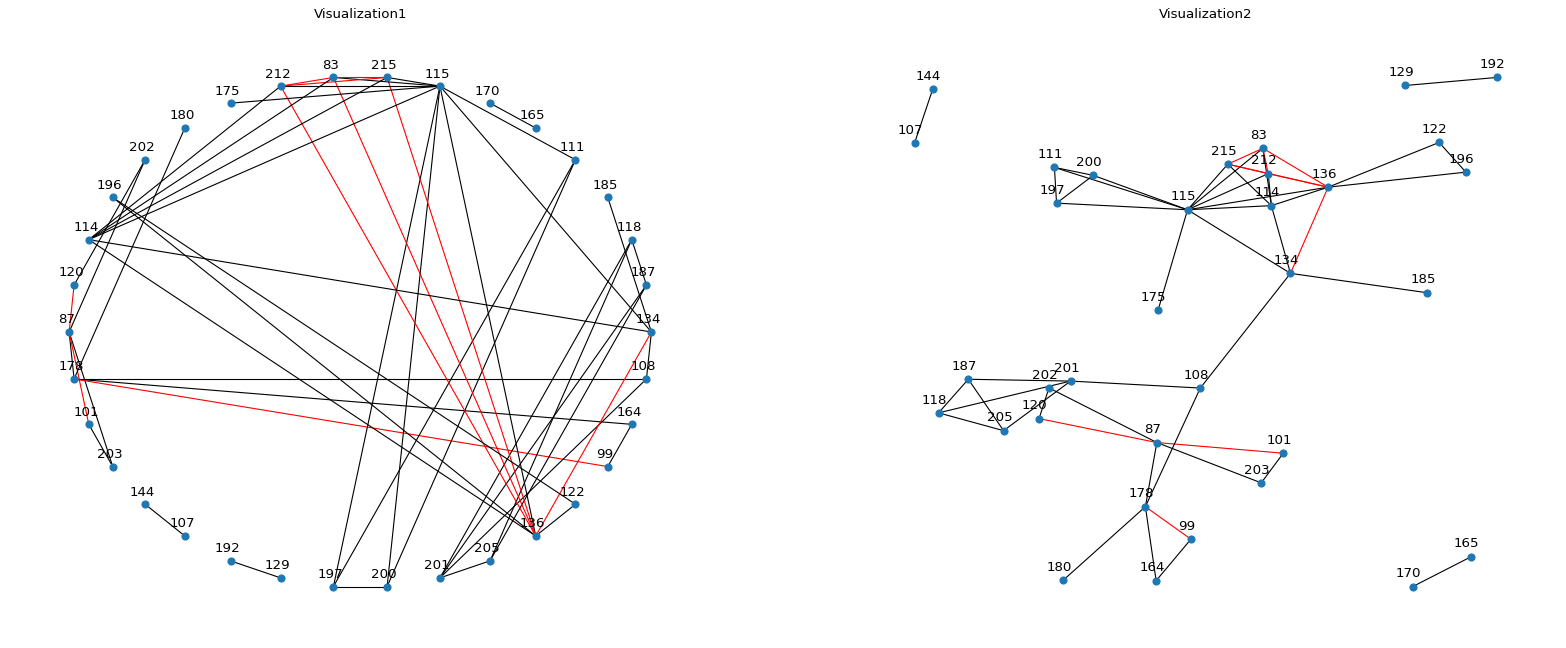

In [38]:
G_new = get_G_new(G, new_link_set_local, 'r')

plot_network(G_new)

#### global results

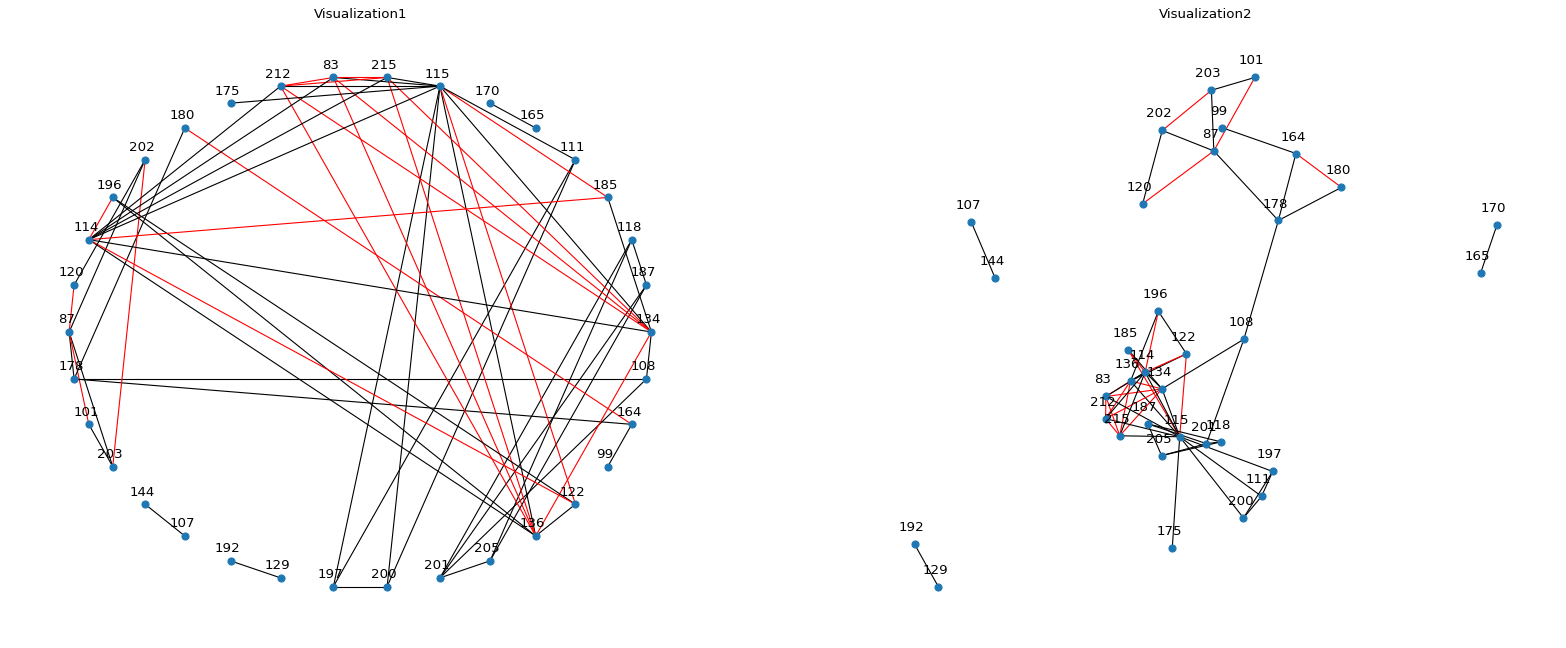

In [39]:
G_new = get_G_new(G, new_link_set_global, 'r')

plot_network(G_new)

#### quasi_local results

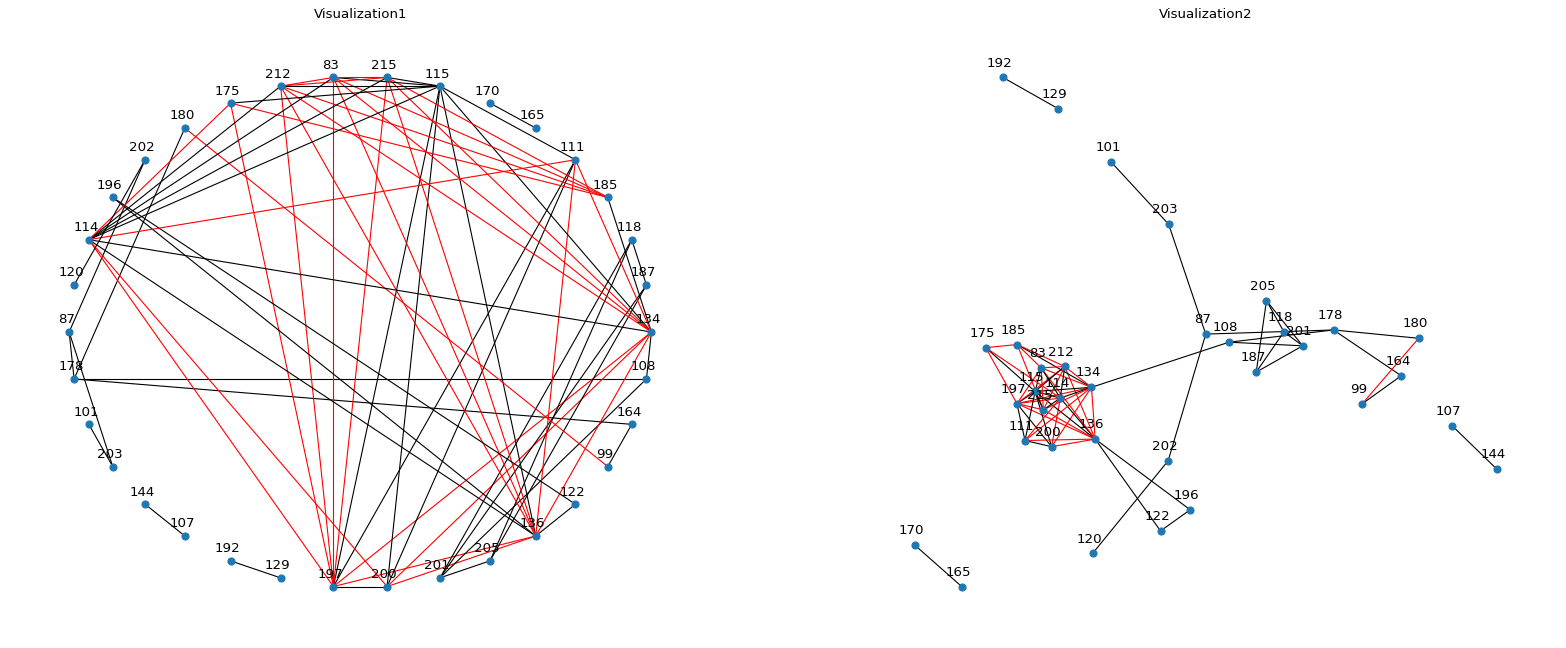

In [40]:
G_new = get_G_new(G, new_link_set_quasi_local, 'r')

plot_network(G_new)

#### Aggregated results
Results of all Similarity Methods aggregating all common predictions.

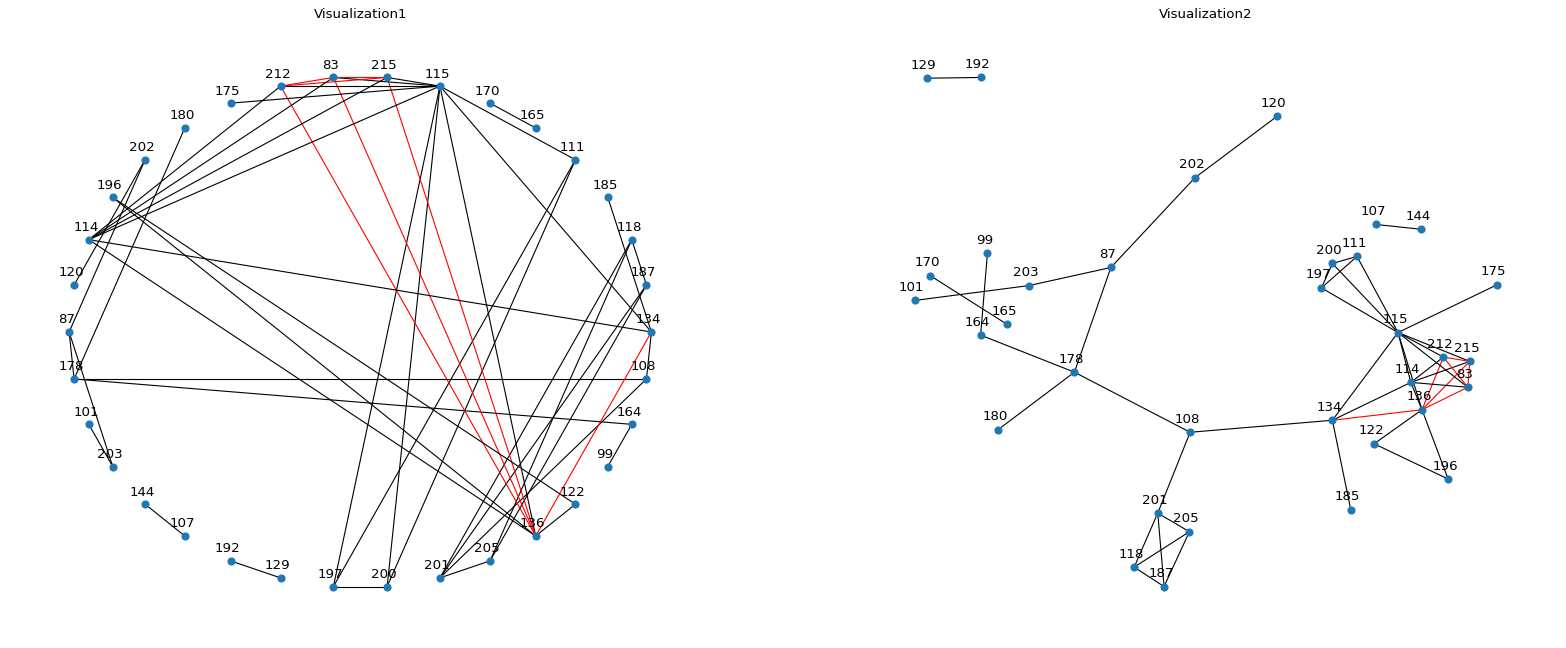

In [41]:
all_similarity = set()
link_intersection = set()
tmp = [new_link_set_global, new_link_set_local, new_link_set_quasi_local]
for pred in tmp:
    all_similarity.update(pred)

link_intersection = new_link_set_global & new_link_set_local & new_link_set_quasi_local
G_new = get_G_new(G, link_intersection, 'r')

plot_network(G_new)

#### stochastic_block_model results

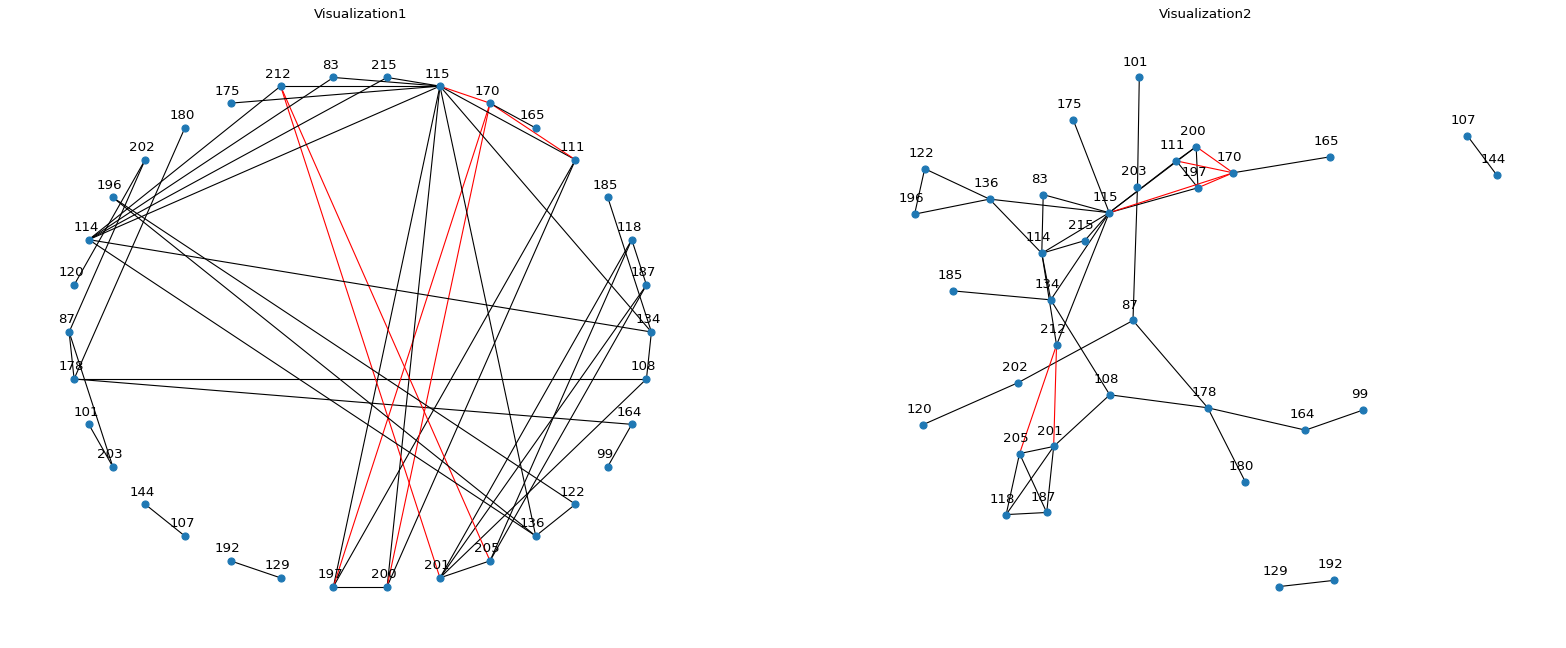

In [42]:
new_links = get_top_predicted_link(predicted_adj_matrix_stochastic_block_model, G.number_of_nodes(), pct_new_link=1, name_index_map=name_index_map)
G_new = get_G_new(G, new_links, 'r')
plot_network(G_new)

#### path_entropy results

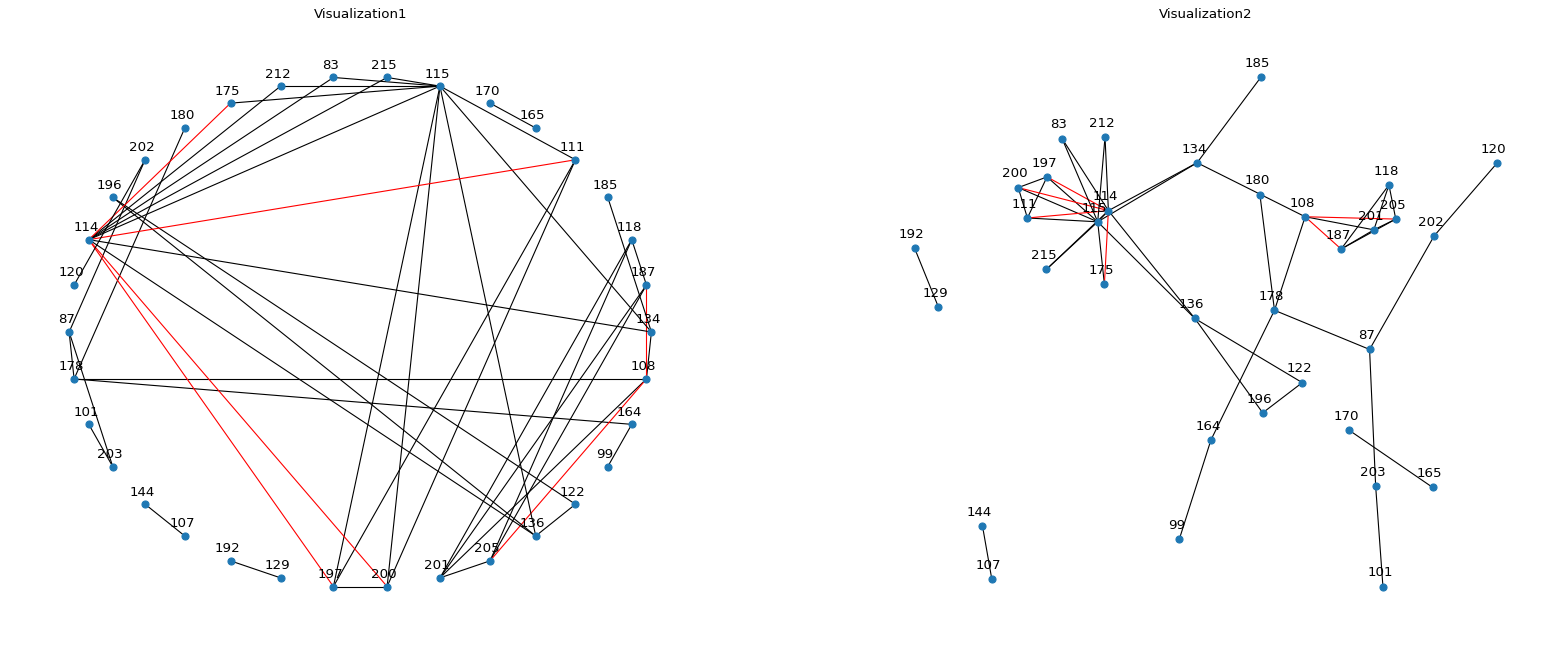

In [43]:
new_links = get_top_predicted_link(predicted_adj_matrix_path_entropy, G.number_of_nodes(), 1, name_index_map)
G_new = get_G_new(G, new_links, 'r')
plot_network(G_new)